---
# Anomaly Detection Project Scratchpad
---

## Imports
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from sklearn import metrics
import env

import acquire as a
import prepare as p

# plotting settings
plt.rc('font', size=12)
plt.rc('figure', figsize=(15, 7))
pd.options.display.float_format = '{:.2f}'.format
sns.set_palette('colorblind')

---
## Acquire
---

In [2]:
# lets get the data
df = a.get_log_data()

In [3]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
1,2018-01-26,09:56:02,java-ii,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.00,97.105.19.61,22.00,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.00


In [4]:
df.shape

(900223, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id          847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       float64
 14  program_id  847330 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 109.9+ MB


Initial Observations:
- None of the dates are in datetime format, that needs to be corrected
    - `date`, `time`, `start_date`, `end_date`, `created_at`, `updated_at`
- The date of access needs to become index column, but I need to figure out how to merge the date and time columns info a single datetime index
- The path column needs to be split out into several columns for future use 
    - Use Zach's function to do this and just make necessary changes for this path format
- `user_id` is the unique identifier for each student
- `cohort_id` and `id` should be the same since that is what I joined on and there should be some nulls somewhere since inner and left join produced different results
    - Take a look at this before dropping one of the columns just to see what's going on
    - These columns are currently both floats, so for whichever I decide to keep, I will most likely convert to integer
- `ip` seems to be able to be left as-is
    - Just need to be careful with this potentially sensitive data
- `name` seems to be good as-is
- `slack` not sure if this will be useful
- `start_date` and `end_date` will allow us to determine if people are accessing the curriculum after they finish and what they are accessing
    - If students are accessing curriculum before their start date, this is an issue since they shouldn't have access until they are granted access through github on the first week or so of class
- `created_at` and `updated_at` columns seem to be just when the entry was created for the cohort identification table
    - Probably won't be super useful
    - Can see if any have been updated since dates seem to be mostly the same
- `deleted_at`
    - See if any were deleted
    - If they were, I would wonder why
- `program_id'
    - This could be mapped to name of program
        - Data Science, Web Dev, and then I would need to ask instructors what any other categories might mean
        - 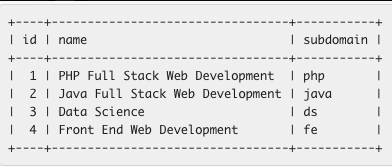

---
## Prepare/Get to know data
---

### `date` and `time`

In [6]:
# add them together as strings
df['date'] = df.date + ' ' + df.time

In [7]:
# and then convert to datetime
df.date = pd.to_datetime(df.date)

In [8]:
# then covert this into index
df = df.set_index(df.date)

In [9]:
# drop columns that have been converted to index
df = df.drop(columns=['date', 'time'])

---
### `path`

In [10]:
df.tail(5)

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,
2021-04-21 16:41:51,jquery/personal-site,64,28.00,71.150.217.33,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00
2021-04-21 16:42:02,jquery/mapbox-api,64,28.00,71.150.217.33,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00
2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.00,71.150.217.33,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00
2021-04-21 16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.00,24.160.137.86,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00
2021-04-21 16:44:39,jquery/mapbox-api,64,28.00,71.150.217.33,28.00,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,NaN,2.00


- Looks like most paths only have 2 parts, the section and the specific page
- I do see some with 1 and 3 though
- Is it even necessary to split up the path?
    - Each current path points to a lesson, so it should be fine as-is
- If I wanted to look at modules instead of lessons, I might need to split it out
    - I will tackle that if I have enough time at the end

In [11]:
# split the path up into sections using the split string method and the "/" as the delimiter
df.path[2].split('/') 

['java-ii', 'object-oriented-programming']

In [12]:
entry = df.path[2]
entry

'java-ii/object-oriented-programming'

In [13]:
parts = entry.split('/')
parts

['java-ii', 'object-oriented-programming']

In [14]:
output = {}

In [15]:
output['module'] = parts[0]
output

{'module': 'java-ii'}

In [16]:
output['lesson'] = parts[1]
output

{'module': 'java-ii', 'lesson': 'object-oriented-programming'}

In [17]:
# my first draft of a function to parse this thing
def parse_path(entry):
    parts = entry.split('/')
    output = {}
    output['module'] = parts[0]
    output['lesson'] = parts[1]
    if len(parts) > 2:
        output['section'] = parts[1:]
    return pd.Series(output)
# this won't work in it's current state because some entries only have 1 item in the list
# would need to either do some cleaning first or add more if statements

In [18]:
# df = df.path.apply(parse_path)

In [19]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [20]:
# find most commonly accessed part of the curriculum accross all cohorts
df.path.value_counts().head(30)

/                                                                            50313
search/search_index.json                                                     19519
javascript-i                                                                 18983
toc                                                                          18297
java-iii                                                                     13733
html-css                                                                     13635
java-ii                                                                      12685
spring                                                                       12524
jquery                                                                       11525
mysql                                                                        11033
java-i                                                                       10865
javascript-ii                                                                10730
appe

In [21]:
df.path.str.split('/')

date
2018-01-26 09:55:03                                                 [, ]
2018-01-26 09:56:02                                            [java-ii]
2018-01-26 09:56:05               [java-ii, object-oriented-programming]
2018-01-26 09:56:06                [slides, object_oriented_programming]
2018-01-26 09:56:24                         [javascript-i, conditionals]
                                             ...                        
2021-04-21 16:41:51                              [jquery, personal-site]
2021-04-21 16:42:02                                 [jquery, mapbox-api]
2021-04-21 16:42:09                          [jquery, ajax, weather-map]
2021-04-21 16:44:37    [anomaly-detection, discrete-probabilistic-met...
2021-04-21 16:44:39                                 [jquery, mapbox-api]
Name: path, Length: 900223, dtype: object

In [22]:
df.path.str.split('/').str[:2]

date
2018-01-26 09:55:03                                                 [, ]
2018-01-26 09:56:02                                            [java-ii]
2018-01-26 09:56:05               [java-ii, object-oriented-programming]
2018-01-26 09:56:06                [slides, object_oriented_programming]
2018-01-26 09:56:24                         [javascript-i, conditionals]
                                             ...                        
2021-04-21 16:41:51                              [jquery, personal-site]
2021-04-21 16:42:02                                 [jquery, mapbox-api]
2021-04-21 16:42:09                                       [jquery, ajax]
2021-04-21 16:44:37    [anomaly-detection, discrete-probabilistic-met...
2021-04-21 16:44:39                                 [jquery, mapbox-api]
Name: path, Length: 900223, dtype: object

In [23]:
# lets just assume that first entry is module and second is lesson
# df['module'] = df.path.str.split('/').str[0]
# df['lesson'] = df.path.str.split('/').str[1]
# this works except you can't tell which module each lesson is in
# will be better to pull them apart and then put them back together only including first 2 parts of path so that each lesson is unique 
# even if different modules have lessons with same name

In [24]:
df.head()

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
2018-01-26 09:56:02,java-ii,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00
2018-01-26 09:56:24,javascript-i/conditionals,2,22.00,97.105.19.61,22.00,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.00


In [25]:
df['module/lesson'] = df.path.str.split('/').str[0] + '/' + df.path.str.split('/').str[1]

In [26]:
df.head()

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,/
2018-01-26 09:56:02,java-ii,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,java-ii/object-oriented-programming
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,slides/object_oriented_programming
2018-01-26 09:56:24,javascript-i/conditionals,2,22.00,97.105.19.61,22.00,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.00,javascript-i/conditionals


In [27]:
# df.lesson.value_counts()

---
### `user_id`

In [28]:
df.head()

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,/
2018-01-26 09:56:02,java-ii,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,java-ii/object-oriented-programming
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,slides/object_oriented_programming
2018-01-26 09:56:24,javascript-i/conditionals,2,22.00,97.105.19.61,22.00,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.00,javascript-i/conditionals


In [29]:
df.user_id.nunique()

981

In [30]:
# who has accessed the curriculum the most?
df.groupby('user_id').path.count().sort_values(ascending=False).head(20)
# is this the correct way to use the groupby?
# I am trying to just get number of requests made by each user and just chose a column to count arbitrarily since it seems that all columns returned the same count

user_id
11     17913
64     16347
53     12329
314     7783
1       7404
495     6451
581     6434
428     5897
344     5460
248     5075
570     4584
315     4510
211     4227
423     3804
555     3687
545     3528
685     3522
524     3512
485     3268
671     3241
Name: path, dtype: int64

In [31]:
# could do the same thing using value counts
df.user_id.value_counts().head(20)

11     17913
64     16347
53     12329
314     7783
1       7404
495     6451
581     6434
428     5897
344     5460
248     5075
570     4584
315     4510
211     4227
423     3804
555     3687
545     3528
685     3522
524     3512
485     3268
671     3241
Name: user_id, dtype: int64

- 981 unique users in this data, numbered from 1 to 981
- Can easily see who is accessing the most using value counts
    - Once `end_date` column is fixed, we can use the datetimes to filter data to only those who are accessing after graduation

---
### `cohort_id` and `id`

In [32]:
df.head()

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,/
2018-01-26 09:56:02,java-ii,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,java-ii/object-oriented-programming
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.00,97.105.19.61,8.00,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,slides/object_oriented_programming
2018-01-26 09:56:24,javascript-i/conditionals,2,22.00,97.105.19.61,22.00,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.00,javascript-i/conditionals


In [33]:
df.cohort_id.nunique()

47

In [34]:
df.name.nunique()

47

In [35]:
df[df.cohort_id != df.id]

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,,,,
2018-01-26 16:46:16,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spring/extra-features
2018-01-26 17:54:24,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:03,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mysql/relationships
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/es6
2021-04-21 12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/map-filter-reduce


- Looks like there are 52,893 rows in the original data where there was no cohort_id to join on
    - These rows will be useful for overall analysis, but will not be helpful when looking at things on a cohort-level

In [36]:
df[df.cohort_id.isna() == True]

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,,,,
2018-01-26 16:46:16,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spring/extra-features
2018-01-26 17:54:24,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:03,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mysql/relationships
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/es6
2021-04-21 12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/map-filter-reduce


In [37]:
df[df.id.isna() == True]

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,,,,
2018-01-26 16:46:16,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spring/extra-features
2018-01-26 17:54:24,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:03,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/
2018-01-26 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mysql/relationships
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/es6
2021-04-21 12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript-ii/map-filter-reduce


In [38]:
# let's drop the id column since these two columns look identical
df = df.drop(columns='id')

In [39]:
# we can also drop the cohort_id column since they are all mapped to names at this point via the merge
df = df.drop(columns='cohort_id')

---
### `ip`

In [40]:
df.ip.value_counts().head(10)

97.105.19.58       284579
97.105.19.61        61662
192.171.117.210      9515
71.150.217.33        6791
76.185.145.231       4754
12.106.208.194       4360
67.11.50.23          4181
70.112.179.142       4117
70.121.183.95        3843
172.124.67.93        3511
Name: ip, dtype: int64

- 5531 different ip addresses
- Top 2 look like they must be associated with Codeup campus

In [41]:
df.ip.isnull().sum()

0

---
### `name`

In [42]:
df.name.value_counts()

Staff         84031
Ceres         40730
Zion          38096
Jupiter       37109
Fortuna       36902
Voyageurs     35636
Ganymede      33844
Apex          33568
Deimos        32888
Darden        32015
Teddy         30926
Hyperion      29855
Betelgeuse    29356
Ulysses       28534
Europa        28033
Xanadu        27749
Bayes         26538
Wrangell      25586
Andromeda     25359
Kalypso       23691
Curie         21582
Yosemite      20743
Bash          17713
Luna          16623
Marco         16397
Easley        14715
Lassen         9587
Arches         8890
Florence       8562
Sequoia        7444
Neptune        7276
Olympic        4954
Kings          2845
Pinnacles      2158
Hampton        1712
Oberon         1672
Quincy         1237
Niagara         755
Mammoth         691
Glacier         598
Joshua          302
Ike             253
Badlands         93
Franklin         72
Apollo            5
Denali            4
Everglades        1
Name: name, dtype: int64

- Nothing much to take away here
- Null are those without `cohort_id`

---
### `slack`

In [43]:
df.slack.nunique()

46

In [44]:
df.name.nunique()

47

In [45]:
df.slack.unique()

array(['#hampton', '#teddy', '#sequoia', '#arches', '#niagara',
       '#pinnacles', '#quincy', nan, '#kings', '#lassen', '#mammoth',
       '#glacier', '#denali', '#joshua', '#olympic', '#ulysses',
       '#badlands', '#apollo', '#ike', '#voyageurs', '#wrangell',
       '#xanadu', '#franklin', '#yosemite', '#', '#zion', '#andromeda',
       '#betelgeuse', '#ceres', '#deimos', '#europa', '#fortuna',
       '#curie', '#apex', '#ganymede', '#everglades', '#hyperion',
       '#darden', '#bash', '#jupiter', '#kalypso', '#luna', '#easley',
       '#marco', '#neptune', '#florence', '#oberon'], dtype=object)

In [46]:
df.name.unique()

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', nan, 'Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Everglades',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'], dtype=object)

- Looks like there is one more cohort than there are slack channels
    - The Bayes cohort appears to have used the `#` slack channel (the same one the instructor's use?)

In [47]:
# we can drop this one as I don't think it will be too useful for our purposes here
df = df.drop(columns='slack')

---
### `start_date` and `end_date`

In [48]:
df.head()

,path,user_id,ip,name,start_date,end_date,created_at,updated_at,deleted_at,program_id,module/lesson
date,,,,,,,,,,,
2018-01-26 09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,/
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,java-ii/object-oriented-programming
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.00,slides/object_oriented_programming
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.00,javascript-i/conditionals


In [49]:
# convert to datetime
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)

In [50]:
df.start_date.min()

Timestamp('2014-02-04 00:00:00')

In [51]:
df.start_date.max()

Timestamp('2021-04-12 00:00:00')

In [52]:
df.end_date.min()

Timestamp('2014-02-04 00:00:00')

In [53]:
df.end_date.max()

Timestamp('2021-10-01 00:00:00')

- these columns will be useful when comparing activity to time in program

---
### `created_at` and `updated_at`

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   path           900222 non-null  object        
 1   user_id        900223 non-null  int64         
 2   ip             900223 non-null  object        
 3   name           847330 non-null  object        
 4   start_date     847330 non-null  datetime64[ns]
 5   end_date       847330 non-null  datetime64[ns]
 6   created_at     847330 non-null  object        
 7   updated_at     847330 non-null  object        
 8   deleted_at     0 non-null       float64       
 9   program_id     847330 non-null  float64       
 10  module/lesson  731934 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 82.4+ MB


In [55]:
# convert to datetime
df.created_at = pd.to_datetime(df.created_at)
df.updated_at = pd.to_datetime(df.updated_at)

In [56]:
df[(df.created_at != df.updated_at) & (df.name.isna() == False)].groupby('name').path.count()

name
Apex       33568
Bash       17713
Niagara      755
Name: path, dtype: int64

- Most cohort info was not ever updated, but 3 cohorts were updated for one reason or another
    - Why were these the only three that were updated? What exactly was updated?

---
### `deleted_at`

In [57]:
df.deleted_at.value_counts()

Series([], Name: deleted_at, dtype: int64)

In [58]:
df.deleted_at.isna().sum()

900223

In [59]:
df.shape

(900223, 11)

- All are empty, can be dropped

In [60]:
df = df.drop(columns='deleted_at')

In [61]:
df.head()

,path,user_id,ip,name,start_date,end_date,created_at,updated_at,program_id,module/lesson
date,,,,,,,,,,
2018-01-26 09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.00,/
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.00,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.00,java-ii/object-oriented-programming
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.00,slides/object_oriented_programming
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.00,javascript-i/conditionals


---
### `program_id`

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   path           900222 non-null  object        
 1   user_id        900223 non-null  int64         
 2   ip             900223 non-null  object        
 3   name           847330 non-null  object        
 4   start_date     847330 non-null  datetime64[ns]
 5   end_date       847330 non-null  datetime64[ns]
 6   created_at     847330 non-null  datetime64[ns]
 7   updated_at     847330 non-null  datetime64[ns]
 8   program_id     847330 non-null  float64       
 9   module/lesson  731934 non-null  object        
dtypes: datetime64[ns](4), float64(1), int64(1), object(4)
memory usage: 75.5+ MB


In [63]:
df.program_id.value_counts()

2.00    713365
3.00    103412
1.00     30548
4.00         5
Name: program_id, dtype: int64

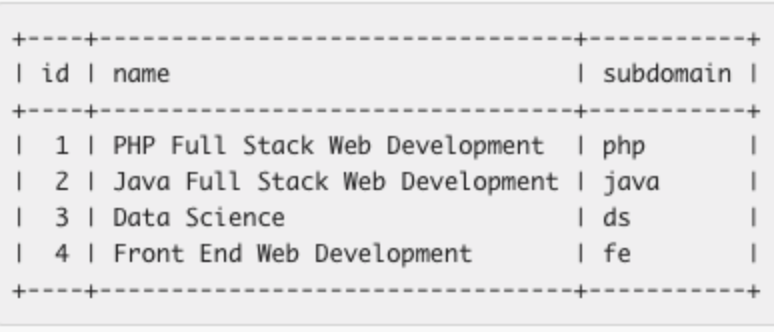

In [64]:
# let's try using mapping and a dictionary instead
program_dict = {
    1 : 'Web Dev - PHP',
    2 : 'Web Dev - Java',
    3 : 'Data Science',
    4 : 'Web Dev - Front End'
}

In [65]:
df['program'] = df.program_id.map(program_dict)

In [66]:
df.program.value_counts()

Web Dev - Java         713365
Data Science           103412
Web Dev - PHP           30548
Web Dev - Front End         5
Name: program, dtype: int64

In [67]:
# we can now drop the program_id column
df = df.drop(columns='program_id')

In [68]:
df.head()

,path,user_id,ip,name,start_date,end_date,created_at,updated_at,module/lesson,program
date,,,,,,,,,,
2018-01-26 09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,/,Web Dev - PHP
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,Web Dev - PHP
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,java-ii/object-oriented-programming,Web Dev - PHP
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,slides/object_oriented_programming,Web Dev - PHP
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,javascript-i/conditionals,Web Dev - Java


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   path           900222 non-null  object        
 1   user_id        900223 non-null  int64         
 2   ip             900223 non-null  object        
 3   name           847330 non-null  object        
 4   start_date     847330 non-null  datetime64[ns]
 5   end_date       847330 non-null  datetime64[ns]
 6   created_at     847330 non-null  datetime64[ns]
 7   updated_at     847330 non-null  datetime64[ns]
 8   module/lesson  731934 non-null  object        
 9   program        847330 non-null  object        
dtypes: datetime64[ns](4), int64(1), object(5)
memory usage: 75.5+ MB


### Compile into prepare script

- See `prepare.py` file    

In [70]:
df = a.get_log_data()

In [71]:
df = p.prep_log(df)

In [72]:
df.shape

(900223, 10)

In [73]:
df.head(20)

,path,user_id,ip,name,start_date,end_date,created_at,updated_at,program,module/lesson
date,,,,,,,,,,
2018-01-26 09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,/
2018-01-26 09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,NaN
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,java-ii/object-oriented-programming
2018-01-26 09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,Web Dev - PHP,slides/object_oriented_programming
2018-01-26 09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,Web Dev - Java,javascript-i/conditionals
2018-01-26 09:56:41,javascript-i/loops,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,Web Dev - Java,javascript-i/loops
2018-01-26 09:56:46,javascript-i/conditionals,3,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,Web Dev - Java,javascript-i/conditionals
2018-01-26 09:56:48,javascript-i/functions,3,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,Web Dev - Java,javascript-i/functions
2018-01-26 09:56:59,javascript-i/loops,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,Web Dev - Java,javascript-i/loops


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   path           900222 non-null  object        
 1   user_id        900223 non-null  int64         
 2   ip             900223 non-null  object        
 3   name           847330 non-null  object        
 4   start_date     847330 non-null  datetime64[ns]
 5   end_date       847330 non-null  datetime64[ns]
 6   created_at     847330 non-null  datetime64[ns]
 7   updated_at     847330 non-null  datetime64[ns]
 8   program        847330 non-null  object        
 9   module/lesson  731934 non-null  object        
dtypes: datetime64[ns](4), int64(1), object(5)
memory usage: 75.5+ MB


In [75]:
df['module/lesson'].isna().sum()

168289

In [76]:
df['module/lesson'].isna().sum() / df.shape[0]

0.18694145783877994

---
## Answer Questions from Email
---

### 1.

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

#### All Programs

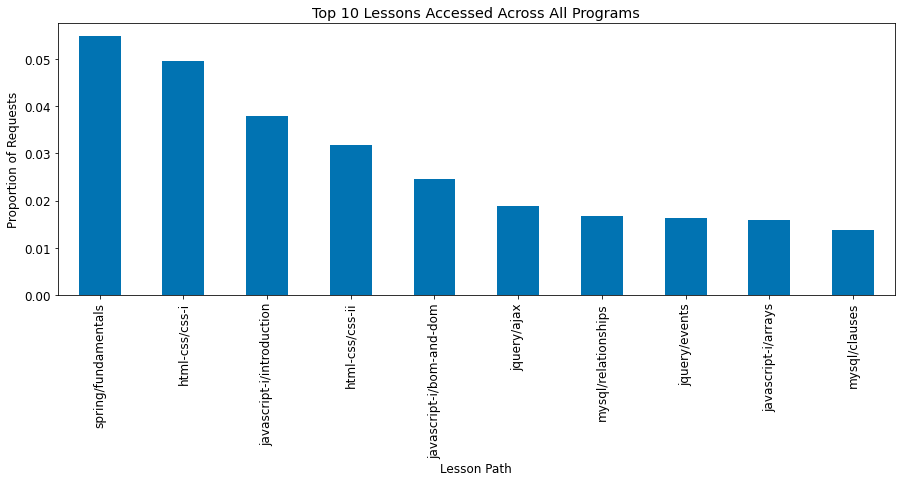

In [77]:
df[(df.path != '/') & (df.path != 'search/search_index.json')]['module/lesson'].value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 10 Lessons Accessed Across All Programs')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');

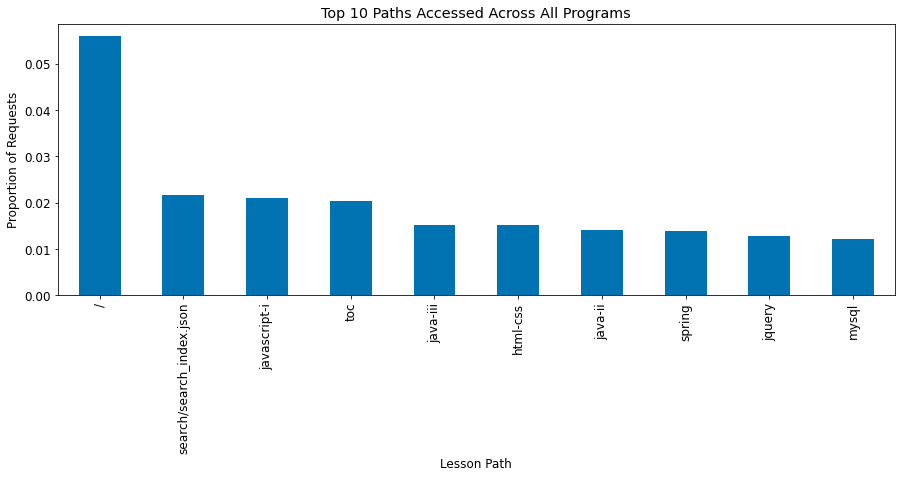

In [78]:
df.path.value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 10 Paths Accessed Across All Programs')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');
# could format the y axis to be more readable here by formatting to be "10k" format

In [79]:
# now lets do it per program
df.program.unique()

array(['Web Dev - PHP', 'Web Dev - Java', nan, 'Web Dev - Front End',
       'Data Science'], dtype=object)

In [80]:
php_df = df[df.program == 'Web Dev - PHP']
java_df = df[df.program == 'Web Dev - Java']
fe_df = df[df.program == 'Web Dev - Front End']
ds_df = df[df.program == 'Data Science']

#### PHP

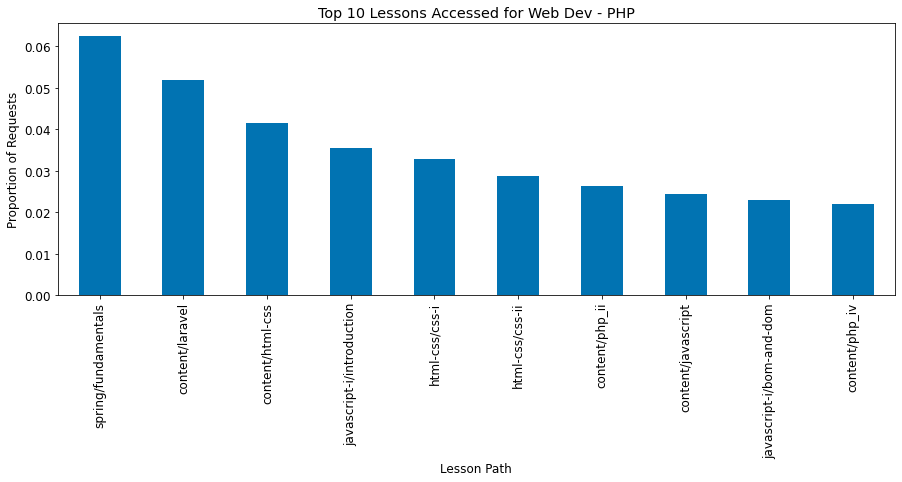

In [81]:
php_df[(php_df.path != '/') & (php_df.path != 'search/search_index.json')]['module/lesson'].value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 10 Lessons Accessed for Web Dev - PHP')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');

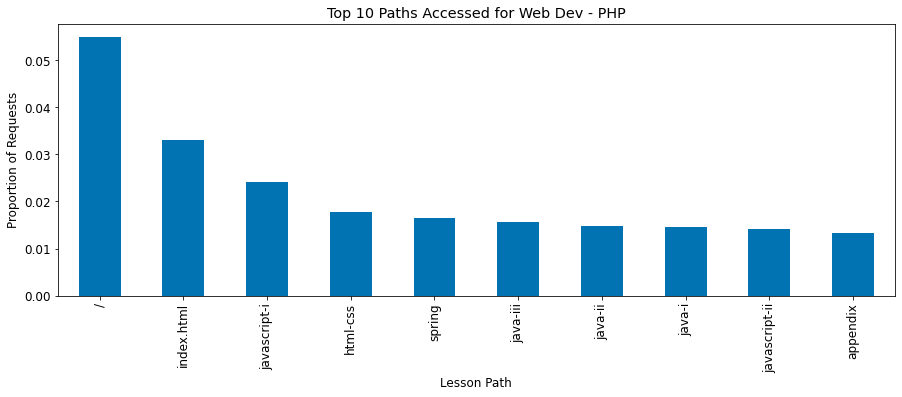

In [82]:
php_df.path.value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 10 Paths Accessed for Web Dev - PHP')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');

#### Java

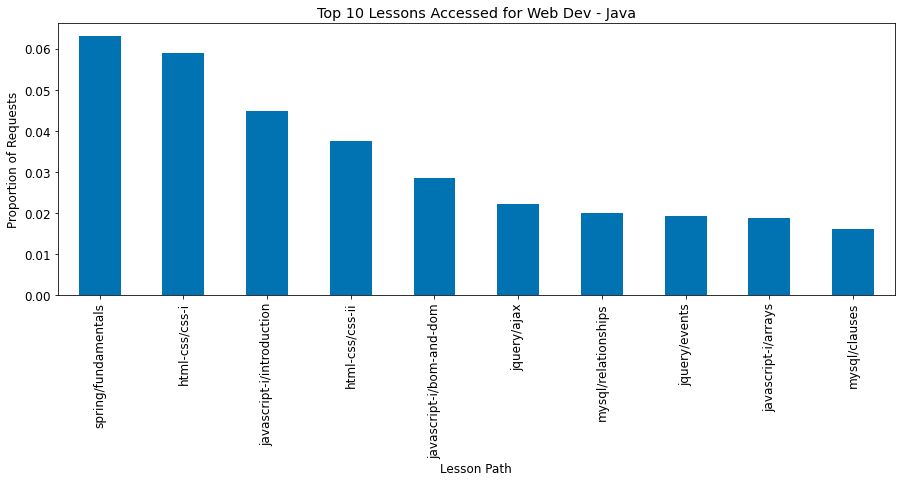

In [83]:
java_df[(java_df.path != '/') & (java_df.path != 'search/search_index.json')]['module/lesson'].value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 10 Lessons Accessed for Web Dev - Java')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');

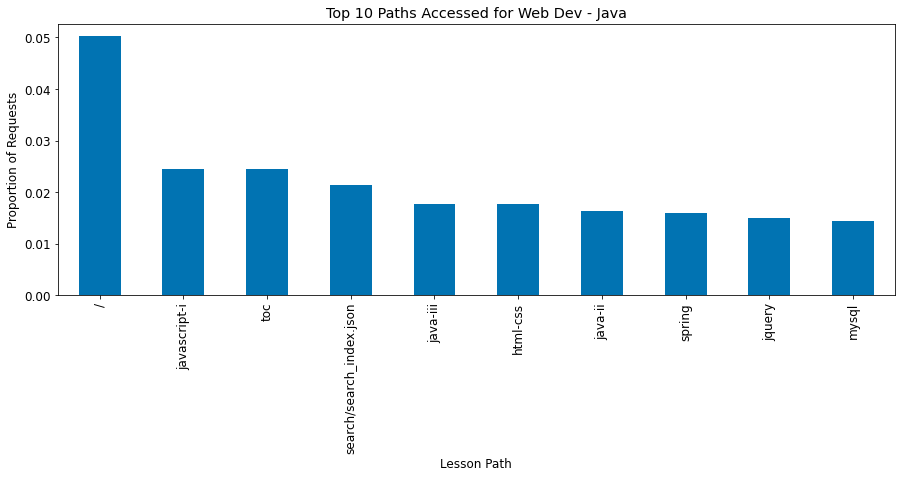

In [84]:
java_df.path.value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 10 Paths Accessed for Web Dev - Java')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');

#### Front End

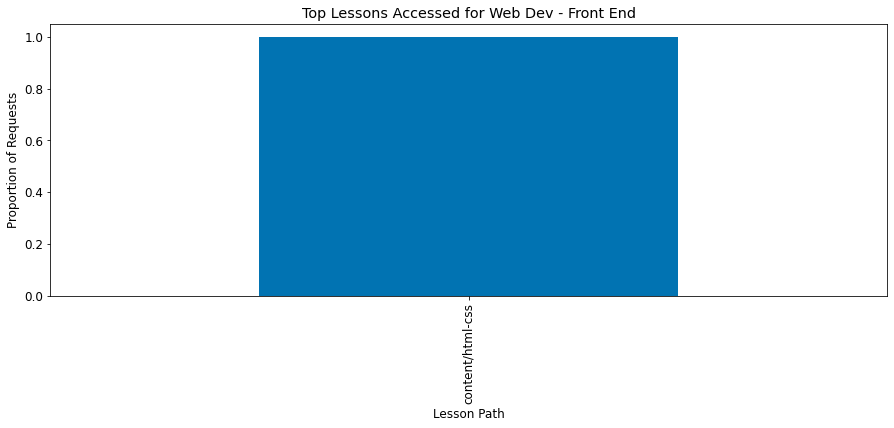

In [85]:
fe_df[(fe_df.path != '/') & (fe_df.path != 'search/search_index.json')]['module/lesson'].value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top Lessons Accessed for Web Dev - Front End')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');

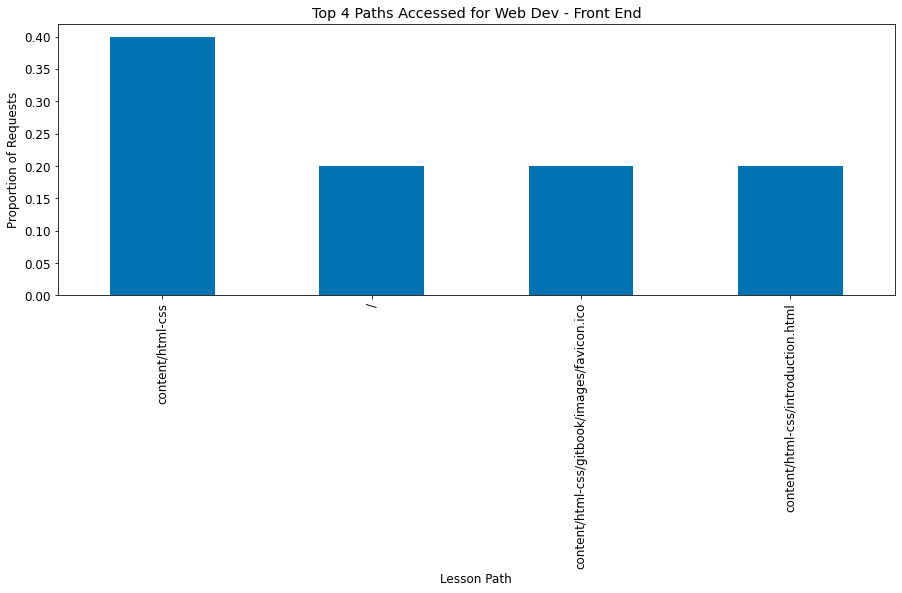

In [86]:
fe_df.path.value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 4 Paths Accessed for Web Dev - Front End')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');

#### Data Science

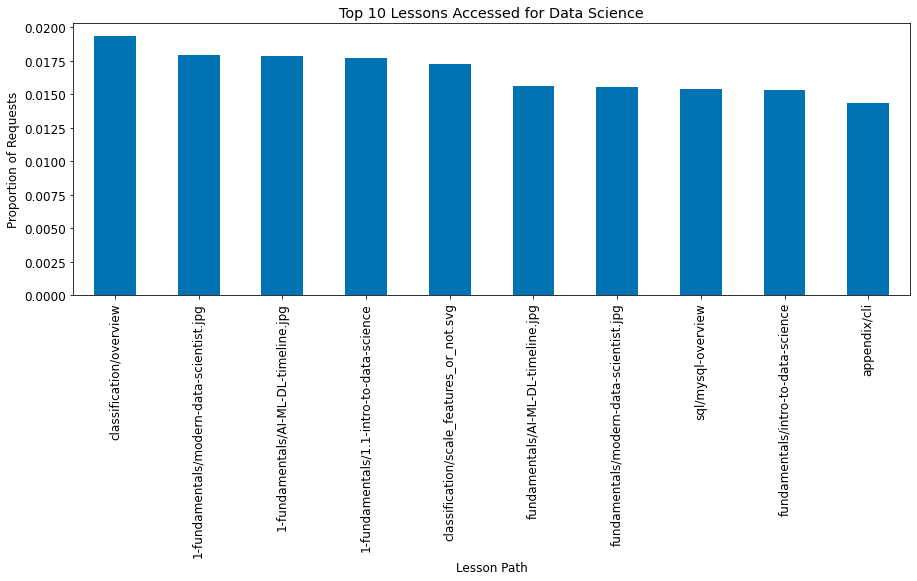

In [87]:
ds_df[(ds_df.path != '/') & (ds_df.path != 'search/search_index.json')]['module/lesson'].value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 10 Lessons Accessed for Data Science')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');

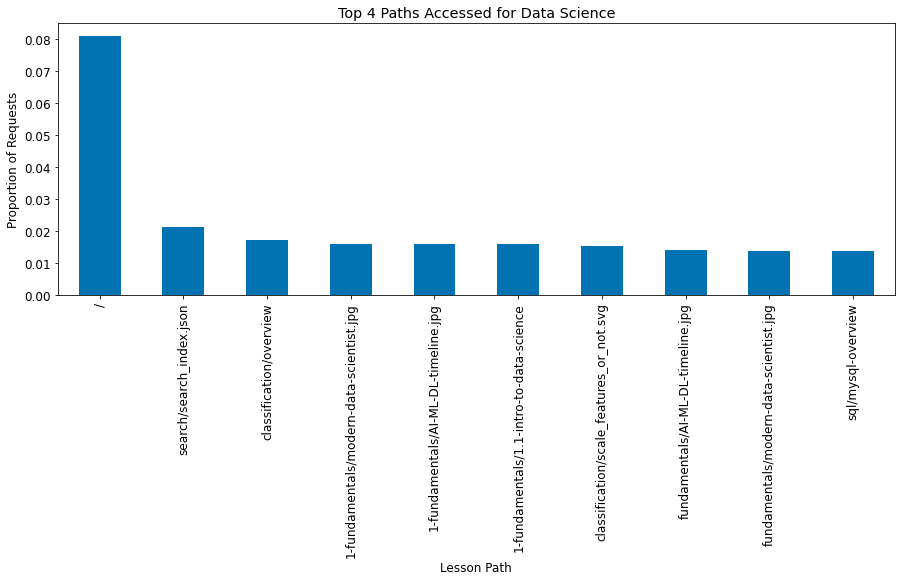

In [88]:
ds_df.path.value_counts(normalize=True).head(10).plot.bar(figsize=(15,5))
plt.title('Top 4 Paths Accessed for Data Science')
plt.xlabel('Lesson Path')
plt.ylabel('Proportion of Requests');

- Not sure how helpful this is
    - Might need to get rid of / since I think that might just be the main page
    - Might also need to get rid of paths ending in .jpg since I'm not sure if that is valuable
        - At the same time, I'm not sure how to split up the path in a way that makes sense
        - Would be nice to have module, lesson, section, image, columns so we could specifically look at lessons, but I'm not sure the formatting of the paths is consistent enough to make that happen

2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

Conditional probability, cohorts given lesson (or vice versa?)

3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

Take subset when date of request is within range of cohort being active and get count of requests per student, sort and see lowest, report top 10

4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

Refer to Madeleine's notebook to identify users with unusually high number of requests or high number of unique requests

5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

Try to identify exact date when this happened? Somehow identify paths as being in ds or webdev and then find counts of requests by program for pages outside of their program

6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

Take subset of post graduation requets given program and unstack

7. Which lessons are least accessed?

Already solved above, also solved by program

8. Anything else I should be aware of?

Take a look at converting to time series data by aggregating and using Bollinger Bands